In [1]:
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit.algorithms.minimum_eigensolvers import SamplingVQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer

In [2]:
from typing import List
import sympy
import numpy as np
import matplotlib.pyplot as plt
import cirq

import cirq_google

working_device = cirq_google.Sycamore
print(working_device)

                                             (0, 5)───(0, 6)
                                             │        │
                                             │        │
                                    (1, 4)───(1, 5)───(1, 6)───(1, 7)
                                    │        │        │        │
                                    │        │        │        │
                           (2, 3)───(2, 4)───(2, 5)───(2, 6)───(2, 7)───(2, 8)
                           │        │        │        │        │        │
                           │        │        │        │        │        │
                  (3, 2)───(3, 3)───(3, 4)───(3, 5)───(3, 6)───(3, 7)───(3, 8)───(3, 9)
                  │        │        │        │        │        │        │        │
                  │        │        │        │        │        │        │        │
         (4, 1)───(4, 2)───(4, 3)───(4, 4)───(4, 5)───(4, 6)───(4, 7)───(4, 8)───(4, 9)
         │        │        │        │        │        │   

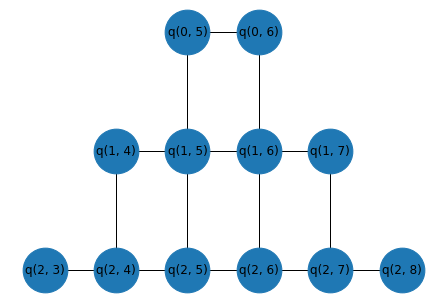

In [3]:
import networkx as nx

# Set the seed to determine the problem instance.
np.random.seed(seed=11)

num_nodes = 12

# Identify working qubits from the device.
device_qubits = working_device.metadata.qubit_set
working_qubits = sorted(device_qubits)[:num_nodes]

# Populate a networkx graph with working_qubits as nodes.
working_graph = working_device.metadata.nx_graph.subgraph(working_qubits)

# Add random weights to edges of the graph. Each weight is a 2 decimal floating point between 0 and 5.
nx.set_edge_attributes(
    working_graph,
    {e: {"weight": np.random.randint(0, 500) / 100} for e in working_graph.edges},
)

# Draw the working_graph on a 2d grid
pos = {q: (q.col, -q.row) for q in working_graph.nodes()}
nx.draw(working_graph, pos=pos, with_labels=True, node_size=2000)
plt.show()

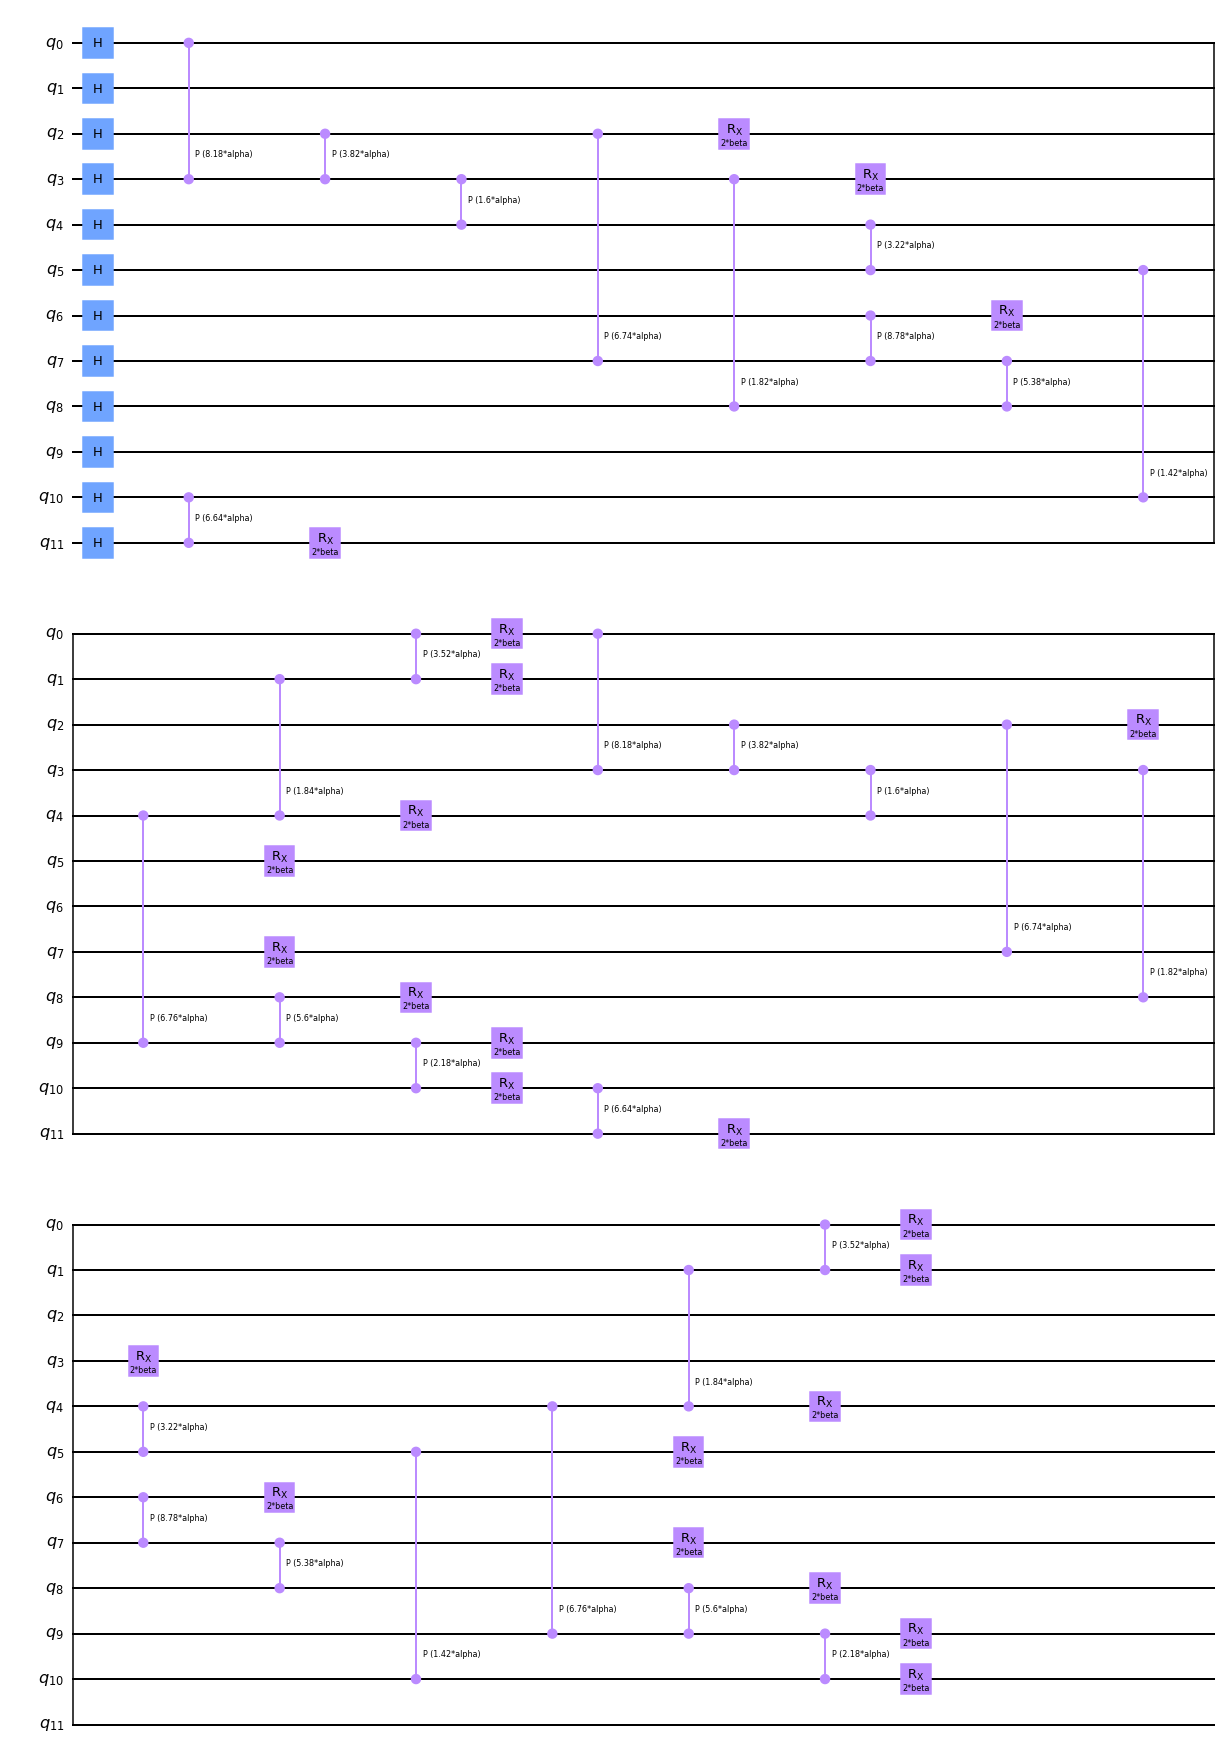

In [4]:
from qiskit import QuantumCircuit, Aer, execute
from qiskit.circuit import ParameterVector, Parameter
import numpy as np

# creating dictionaries for smooth switching between qubit index in qiskit and qubit name in sycamore circuit
names = {}
indices = {}

for index, qubit_name in list(enumerate(working_qubits)):
    names['{}'.format(qubit_name)] = index
    indices['{}'.format(index)] = qubit_name

# defining the parameters to parameterize the Controlled-Phase gates    
alpha = Parameter("alpha")
beta = Parameter("beta")

# making the QAOA circuit
qaoa_circuit = QuantumCircuit(num_nodes)

# applying the hadamard gate on each qubit to put them in a uniform superposition
qaoa_circuit.h(range(len(working_graph.nodes())))

# setting the number of times the sequence of controlled phase gates and Rx rotations have to be repeated
p = 2

for i in range(p):

    # controlled phase gate operations between the pairs of qubits connected with edges, with one of them as control qubit
    for u, v, w in working_graph.edges(data=True):
        qaoa_circuit.cp(2 * alpha * w["weight"], names['{}'.format(u)], names['{}'.format(v)])

    # applying parameterized X rotations on each qubit
    for qubit in working_graph.nodes():
        qaoa_circuit.rx(2 * beta, names['{}'.format(qubit)])

qaoa_circuit.draw('mpl')

In [5]:
# defining a cost function
# each qubit will be measured as either 0 or 1 and they'll form 2 subsets of qubits
def estimate_cost(graph: nx.Graph, samples: dict) -> float:

    cost = 0

    for node1, node2, w in graph.edges(data=True):

        product = 0
        
        # the eigenvalue of a qubit measured as 0 would be +1 (i.e., (-1)**0)
        # the eigenvalue of a qubit measured as 1 would be -1 (i.e., (-1)**1)
        # here, we measure the eigenvalues of the two connected nodes
        for key in samples:
            eigenval1 = (-1)**int('{}'.format(key[11-names['{}'.format(node1)]]))
            eigenval2 = (-1)**int('{}'.format(key[11-names['{}'.format(node2)]]))

            # if the product is positive then they're in the same subset and contribute +1 to the cost, otherwise, -1
            # the third term signifies the number of times this particular combination of result is obtained in the samples
            product += eigenval1*eigenval2*samples['{}'.format(key)]

        # 20000 samples are observed and the mean is evaluated
        shots = 20000    
        mean = product/shots
        
        # final cost is estimated as a weighted sum of the means obtained for each pair of nodes
        cost += mean*w['weight']
    
    return -cost

In [6]:
# randomly selected parameter values
alpha_value = np.pi / 4
beta_value = np.pi / 2
    
# binding parameter values to the circuit
qaoa_circuit1 = qaoa_circuit.bind_parameters(dict(zip(qaoa_circuit.parameters, [alpha_value, beta_value])))

# measuring the state of all the qubits
qaoa_circuit1.measure_all()

# we use the qasm simulator
simulator = Aer.get_backend('qasm_simulator')

# executing the circuit to get the result
job = execute(qaoa_circuit1, simulator, shots = 20000)
result = job.result()

# getting the counts from the result
counts = result.get_counts(qaoa_circuit1)

# Print the results
print(f"Alpha = {round(alpha_value, 3)} Beta = {round(beta_value, 3)}")
print(f"Estimated cost: {estimate_cost(working_graph, counts)}")

Alpha = 0.785 Beta = 1.571
Estimated cost: -0.051207


In [7]:
# grid size can be changed to check the cost over a fine range
grid_size = 5

# evaluating cost over a range of parameter values to get the optimized cost 
alpha_values = np.linspace(0, 2*np.pi, grid_size)
beta_values = np.linspace(0, 2*np.pi, grid_size)

# a list to store the values of costs for different set of parameters
exp_values = []

# a list to store the different sets of parameters
par_tuples = []

for alpha_val in alpha_values:
    for beta_val in beta_values:
        
        alpha = Parameter("alpha")
        beta = Parameter("beta")

        qaoa_circuit1 = qaoa_circuit.bind_parameters(dict(zip(qaoa_circuit.parameters, [alpha_val, beta_val])))
        qaoa_circuit1.measure_all()
        job = execute(qaoa_circuit1, simulator, shots=20000)
        result = job.result().get_counts()
        cost = estimate_cost(working_graph, result)
        exp_values.append(cost)

        par_tuples.append((alpha_val, beta_val))

par_values = np.reshape(par_tuples, (-1, grid_size, 2))
exp_values = np.reshape(exp_values, (-1, grid_size)).tolist()

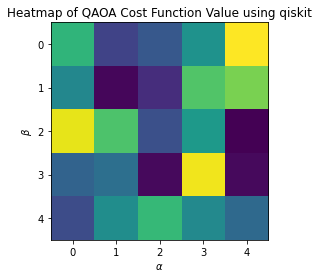

In [8]:
plt.title("Heatmap of QAOA Cost Function Value using qiskit")
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\beta$")
plt.imshow(exp_values)
plt.show()

In [9]:
# defining a function to plot and output the graph cut information

def output_cut(s_partition: List[cirq.Qid]) -> None:

    # generate the colors
    coloring = []
    for node in working_graph:
        if node in s_partition:
            coloring.append("blue")
        else:
            coloring.append("red")

    # get the weights
    edges = working_graph.edges(data=True)
    weights = [w["weight"] for (u, v, w) in edges]

    nx.draw_circular(
        working_graph,
        node_color=coloring,
        node_size=2000,
        with_labels=True,
        width=weights,
    )
    plt.show()
    size = nx.cut_size(working_graph, s_partition, weight="weight")
    print(f"Cut size: {size}")

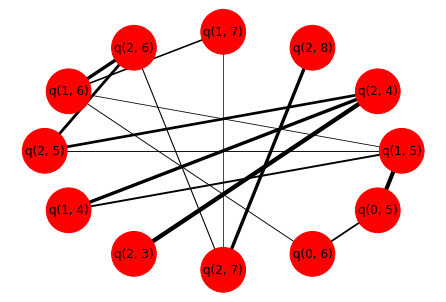

Cut size: 0


In [10]:
# test with the empty S and all nodes placed in T
output_cut([])

In [11]:
# finding the index of the best cost
best_exp_index = np.unravel_index(np.argmax(exp_values), np.array(exp_values).shape)
print(best_exp_index, type(best_exp_index))

# finding the parameters corresponding to the optimal cost
best_parameters = par_values[best_exp_index]
print(f"Best control parameters: {best_parameters}")

(0, 4) <class 'tuple'>
Best control parameters: [0.         6.28318531]


In [12]:
# now we shall use the best parameters to get the cut
num_cuts = 100

# binding the best parameters to the QAOA circuit and measuring the qubits
qaoa_circuit2 = qaoa_circuit.bind_parameters(dict(zip(qaoa_circuit.parameters, [best_parameters[0], best_parameters[1]])))
qaoa_circuit2.measure_all()
results = execute(qaoa_circuit2, Aer.get_backend('qasm_simulator'), shots = num_cuts).result().get_counts()

best_qaoa_S_partition = set()
best_qaoa_T_partition = set()
best_qaoa_cut_size = -np.inf

# the circuit is measuring 'num_cuts' times and a key is obtained each time
# each key is a string of bits to which the qubit collapses upon measurement
# the key with the best cut is considered for making the 2 subsets
for key in results:

    S_partition = set()
    T_partition = set()

    i = 0
    
    for i in range(12):
        if key[11-i] == '1':
            S_partition.add(indices[str(11-int('{}'.format(i)))])
        if key[11-i] == '0':
            T_partition.add(indices[str(11-int('{}'.format(i)))])
        
        cut_size = nx.cut_size(working_graph, S_partition, T_partition, weight="weight")
        
        if cut_size > best_qaoa_cut_size:
            best_qaoa_cut_size = cut_size
            best_qaoa_S_partition = S_partition
            best_qaoa_T_partition = T_partition

In [13]:
# we shall also check a random cut
import random

best_random_S_partition = set()
best_random_T_partition = set()
best_random_cut_size = -9999

i = 0

# randomly add a qubit to a subset
for i in range(num_cuts):
    S_partition = set()
    T_partition = set()
    
    for node in working_graph:
        if random.random() > 0.5:
            S_partition.add(node)
        else:
            T_partition.add(node)

    cut_size = nx.cut_size(working_graph, S_partition, T_partition, weight="weight")

    # keep the best cut
    if cut_size > best_random_cut_size:
        best_random_cut_size = cut_size
        best_random_S_partition = S_partition
        best_random_T_partition = T_partition

-----QAOA-----


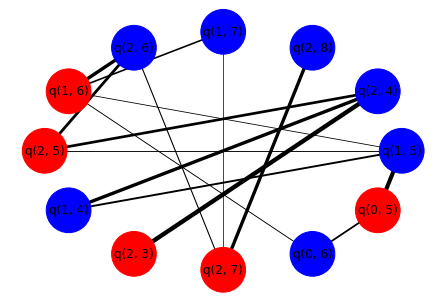

Cut size: 28.470000000000002


-----RANDOM-----


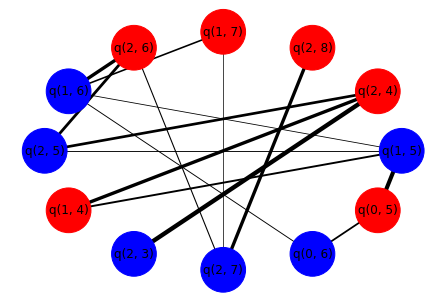

Cut size: 27.750000000000004


In [14]:
print("-----QAOA-----")
output_cut(best_qaoa_S_partition)

print("\n\n-----RANDOM-----")
output_cut(best_random_S_partition)

In [15]:
# for using the qiskit's maxcut class, we first convert the problem to a hamiltonian
# we start by storing the weights in a matrix

weights = np.zeros([num_nodes, num_nodes])
for i in range(num_nodes):
    for j in range(num_nodes):
        temp = working_graph.get_edge_data(indices['{}'.format(i)], indices['{}'.format(j)], default=0)
        if temp != 0:            
            weights[i, j] = temp["weight"]
print(weights)

[[0.   1.76 0.   4.09 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [1.76 0.   0.   0.   0.92 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   1.91 0.   0.   0.   3.37 0.   0.   0.   0.  ]
 [4.09 0.   1.91 0.   0.8  0.   0.   0.   0.91 0.   0.   0.  ]
 [0.   0.92 0.   0.8  0.   1.61 0.   0.   0.   3.38 0.   0.  ]
 [0.   0.   0.   0.   1.61 0.   0.   0.   0.   0.   0.71 0.  ]
 [0.   0.   0.   0.   0.   0.   0.   4.39 0.   0.   0.   0.  ]
 [0.   0.   3.37 0.   0.   0.   4.39 0.   2.69 0.   0.   0.  ]
 [0.   0.   0.   0.91 0.   0.   0.   2.69 0.   2.8  0.   0.  ]
 [0.   0.   0.   0.   3.38 0.   0.   0.   2.8  0.   1.09 0.  ]
 [0.   0.   0.   0.   0.   0.71 0.   0.   0.   1.09 0.   3.32]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   3.32 0.  ]]


In [16]:
# the weight matrix is fed to the Maxcut class
max_cut = Maxcut(weights)

# the problem is converted to an unconstrained quadratic problem
qp = max_cut.to_quadratic_program()

print(qp.prettyprint())

Problem name: Max-cut

Maximize
  -3.52*x_0*x_1 - 8.18*x_0*x_3 - 1.84*x_1*x_4 - 6.64*x_10*x_11 - 3.82*x_2*x_3
  - 6.74*x_2*x_7 - 1.6*x_3*x_4 - 1.82*x_3*x_8 - 3.22*x_4*x_5 - 6.76*x_4*x_9
  - 1.42*x_5*x_10 - 8.78*x_6*x_7 - 5.38*x_7*x_8 - 5.6*x_8*x_9 - 2.18*x_9*x_10
  + 5.85*x_0 + 2.68*x_1 + 5.12*x_10 + 3.32*x_11 + 5.28*x_2 + 7.71*x_3 + 6.71*x_4
  + 2.3200000000000003*x_5 + 4.39*x_6 + 10.45*x_7 + 6.4*x_8 + 7.27*x_9

Subject to
  No constraints

  Binary variables (12)
    x_0 x_1 x_2 x_3 x_4 x_5 x_6 x_7 x_8 x_9 x_10 x_11



In [17]:
# finally, it is converted to an Ising Hamiltonian

qubitOp, offset = qp.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: -16.874999999999993
Ising Hamiltonian:
0.88 * IIIIIIIIIIZZ
+ 2.045 * IIIIIIIIZIIZ
+ 0.955 * IIIIIIIIZZII
+ 0.46 * IIIIIIIZIIZI
+ 0.4 * IIIIIIIZZIII
+ 0.805 * IIIIIIZZIIII
+ 1.685 * IIIIZIIIIZII
+ 2.195 * IIIIZZIIIIII
+ 0.455 * IIIZIIIIZIII
+ 1.345 * IIIZZIIIIIII
+ 1.69 * IIZIIIIZIIII
+ 1.4 * IIZZIIIIIIII
+ 0.355 * IZIIIIZIIIII
+ 0.545 * IZZIIIIIIIII
+ 1.66 * ZZIIIIIIIIII


In [18]:
# the eigenvalue of the Hamiltonian is optimized using an optimizer
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qp)
print(result.prettyprint())

objective function value: 33.75
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0, x_4=1.0, x_5=0.0, x_6=1.0, x_7=0.0, x_8=1.0, x_9=0.0, x_10=1.0, x_11=0.0
status: SUCCESS
